# Exponential-family EKF

$$
\begin{aligned}
    p(\theta_t \vert \theta_{t-1}) &= {\cal N}(\theta_t \vert \theta_{t-1}, Q_t)\\
    p(y_t \vert \theta_{t}, {\bf x}_t) &= \text{expfam}(y_t \vert h(\theta_t, {\bf x}_t))\\
\end{aligned}
$$

In [31]:
import jax
import chex
import einops
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_moons, make_biclusters
from jax.flatten_util import ravel_pytree
from matplotlib.animation import FuncAnimation

# !pip install git+https://github.com/gerdm/rebayes-mini
from rebayes_mini.methods import extended_kalman_filter as ekf

In [2]:
%config InlineBackend.figure_format = "retina"

## Bernoulli

Log-partition is given by

$$
    A(\eta) = \log(1 + \exp(\eta))
$$

In [3]:
n_samples = 200
data = make_moons(n_samples=n_samples, random_state=314, noise=0.15)
X, y = jax.tree_map(jnp.array, data)

key = jax.random.PRNGKey(314)

In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)

In [10]:
@jax.jit
def log_partition(eta):
    return jnp.log1p(jnp.exp(eta)).sum()

@jax.jit
def suff_stat(y):
    return y


agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=2.0)
bel, bel_hist = agent.scan(bel_init, X, y)

In [12]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [13]:
(y == yhat.squeeze()).mean()

Array(0.935, dtype=float32)

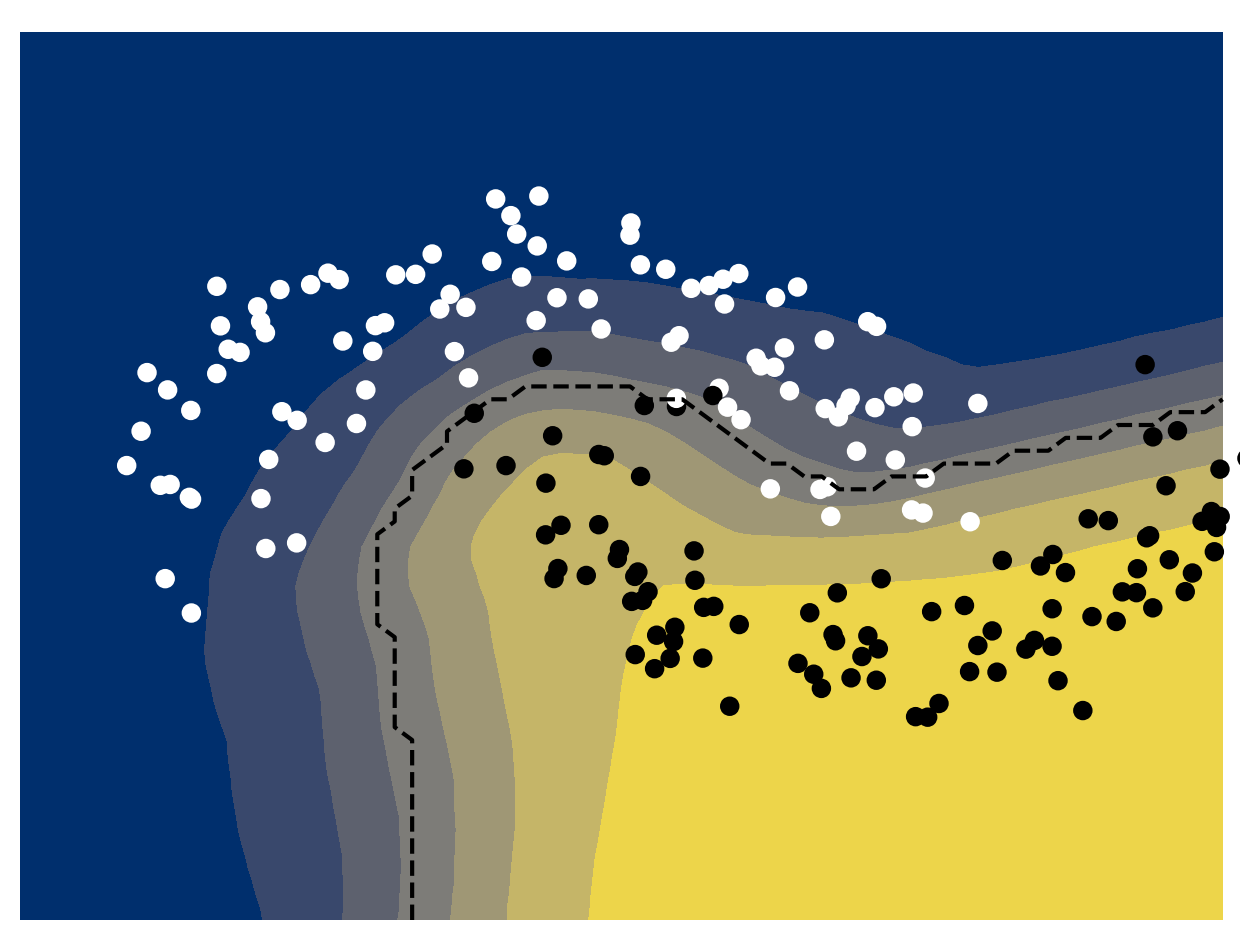

In [15]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="cividis")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="bone_r")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Animating

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_4141151/2564906369.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


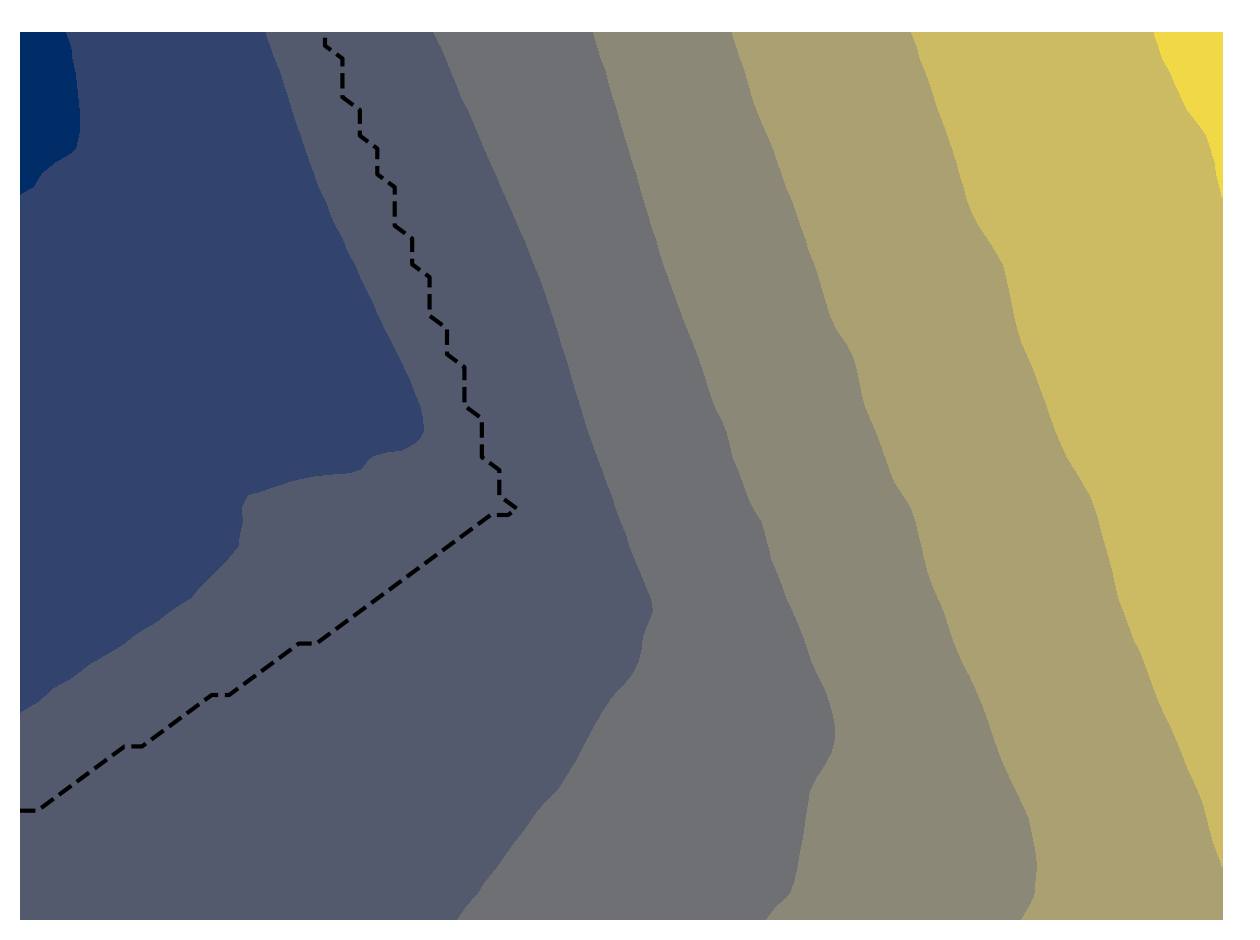

In [16]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = np.array(agent.link_fn(bel.mean, Xeval).squeeze())
    mean_Z = agent.mean(Z)
    plt.contourf(*XX, mean_Z, cmap="cividis")
    plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
    plt.scatter(*np.array(X)[:t].T, c=y[:t], cmap="bone_r")
    plt.ylim(-1.5, 2)
    plt.xlim(-1.5, 2)
    plt.axis("off")
    plt.tight_layout()

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("bern-ekf.gif", fps=20)

## Multinomial

The log-partition takes the form

$$
    \log A(\boldsymbol\eta) = \log\left(\sum_{k=1}^K\exp(\eta_k)\right)
$$

In [17]:
n_obs = 400
k = 3 # TODO: remove hard-code
X, y, _ = make_biclusters((n_obs, 2), k, noise=20, random_state=31415, shuffle=False)
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

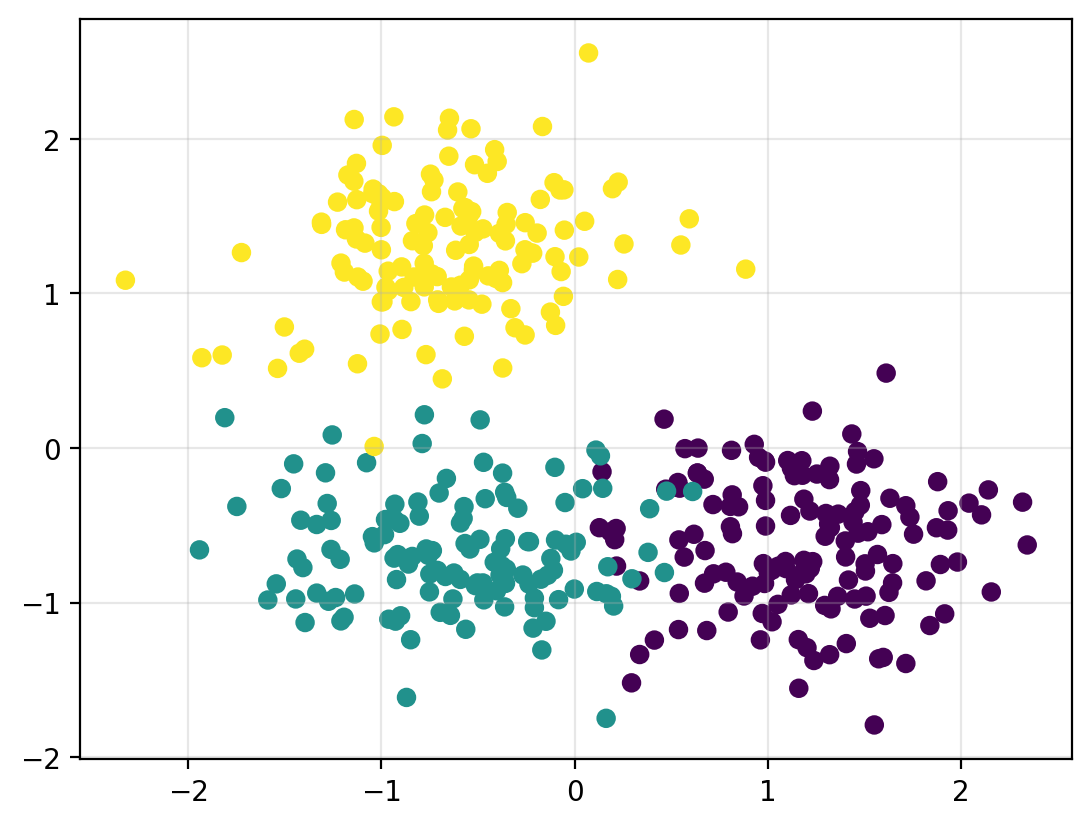

In [18]:
plt.scatter(*X.T, c=y.argmax(axis=0))
plt.grid(alpha=0.3)

In [19]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        
        eta = nn.Dense(k)(x)
        return eta
    
model = MLP()
params = model.init(key, X)

In [20]:
ycat = y.argmax(axis=0).astype(float)

In [21]:
def log_partition(eta):
    eta = jnp.append(eta, 0.0)
    return jax.nn.logsumexp(eta).sum()

def suff_stat(y):
    return y

agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=1e-3)
bel, bel_hist = agent.scan(bel_init, X, y.T[:, :])

In [24]:
# Link function
eta = agent.link_fn(bel_init.mean, X[0])

In [25]:
agent.mean(eta)

Array([0.06629858, 0.5084508 , 0.24127457], dtype=float32)

In [28]:
agent.covariance(eta)

Array([[ 0.06190308, -0.03370956, -0.01599616],
       [-0.03370956,  0.24992862, -0.12267622],
       [-0.01599616, -0.12267622,  0.18306115]], dtype=float32)

In [29]:
etas = agent.link_fn(bel.mean, X)
yhat = jax.vmap(agent.mean)(etas)
yhat_cat = yhat.argmax(axis=1)
(yhat_cat == ycat).mean()

Array(0.94, dtype=float32)

In [32]:
confusion_matrix(ycat, yhat_cat)

array([[141,   0,   0],
       [ 16, 110,   0],
       [  0,   8, 125]])

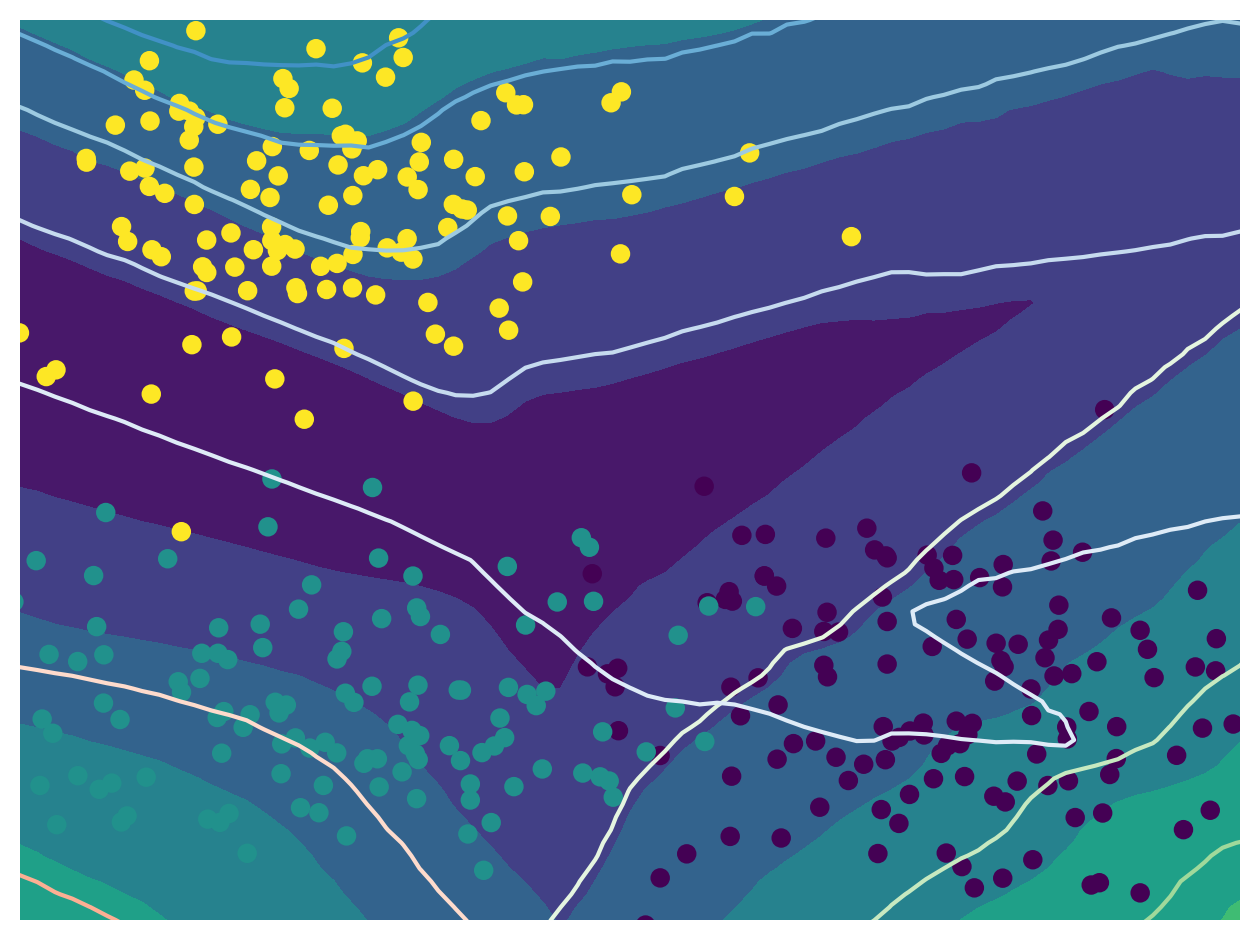

In [34]:
XX = np.mgrid[-2.5:2.5:0.05, -2.5:2.5:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, Z.max(axis=-1), cmap="viridis")
plt.contour(*XX, mean_Z[..., 0], cmap="Greens")
plt.contour(*XX, mean_Z[..., 1], cmap="Reds")
plt.contour(*XX, mean_Z[..., 2], cmap="Blues")

plt.scatter(*np.array(X).T, c=ycat)
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = agent.link_fn(bel.mean, Xeval).squeeze()
    plt.imshow(Z, extent=[-2.5, 2.5, -2.5, 2.5])
    plt.scatter(*np.array(X[:t]).T, c=ycat[:t], cmap="viridis_r", s=20)
    plt.scatter(*np.array(X[t]), c="red", s=30)
    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.5, 2.5)
    plt.axis("off")
    plt.tight_layout()

frames = np.arange(n_obs)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("mult-ekf.gif", fps=20)

# Gaussian: Heteroskedastic

Log-partition is given by

$$
    A(\boldsymbol\eta) = A(\eta_1, \eta_2) = -\frac{\eta_1^2}{4\eta_2} - \frac{1}{2}\log(-2\eta_2)
$$

In [37]:
def basis_transform(domain):
    return jnp.c_[domain, domain ** 2]

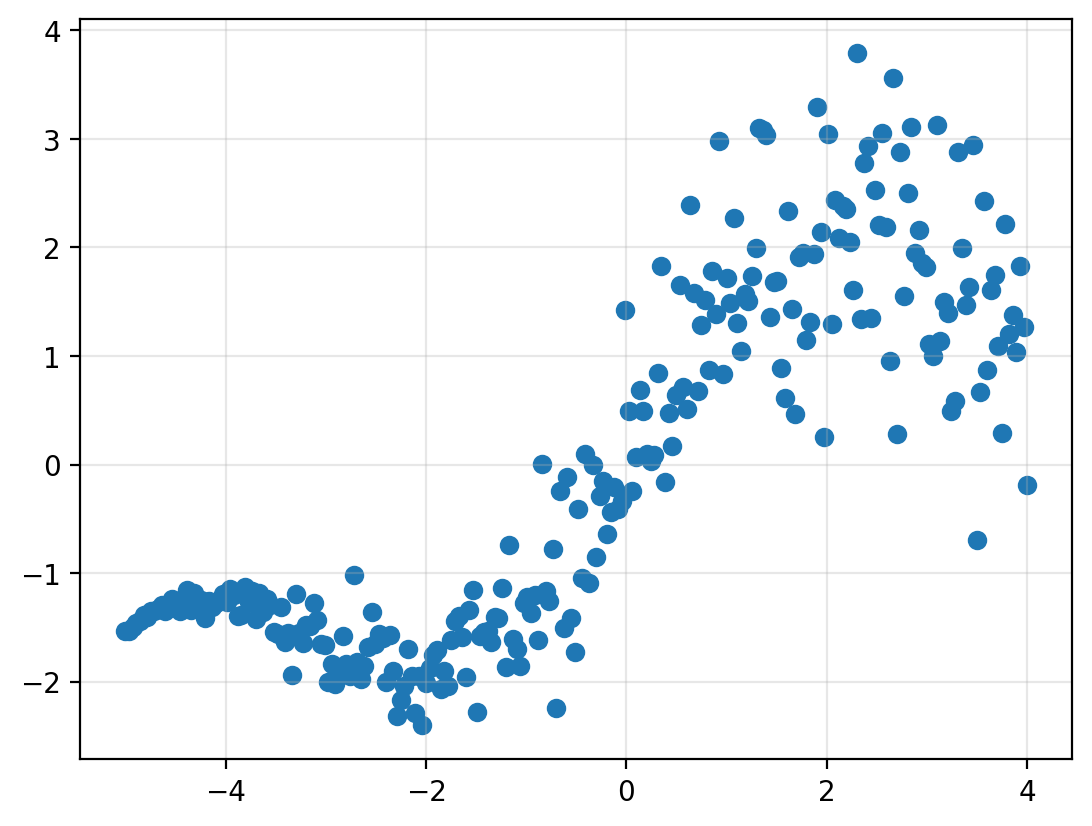

In [38]:
key = jax.random.PRNGKey(314)
key_data, key_train = jax.random.split(key)

n_samples = 250
key_x, key_y = jax.random.split(key_data)

key_noise, key_y = jax.random.split(key_y)
err = jax.random.normal(key_y, (n_samples,))

x = jnp.linspace(-5, 4, n_samples)

scales = jnp.linspace(0.01, 1.0, n_samples)
# scales = np.sqrt(jnp.exp(x / 2))
err = err * scales


y_clean = 0.5 * x + jnp.sin(x)
y = y_clean + err

ixs_new = jax.random.choice(key_x, n_samples, (n_samples,), replace=False)
x, y = x[ixs_new], y[ixs_new]
y_clean = y_clean[ixs_new]

X = basis_transform(x[:, None])

plt.scatter(x, y)
plt.grid(alpha=0.3)

In [39]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        
        eta1 = nn.Dense(50)(x)
        eta1 = nn.relu(eta1)
        eta1 = nn.Dense(1)(eta1)
        
        eta2 = nn.Dense(50)(x)
        eta2 = nn.relu(eta2)
        eta2 = nn.Dense(1)(eta2)
        
        eta = jnp.array([eta1, -jnp.exp(eta2)]).squeeze()
        return eta
    
model = MLP()
params = model.init(key_train, X)

In [40]:
@jax.jit
def log_partition(eta):
    eta1, eta2 = eta
    return -eta1 ** 2 / (4 * eta2) - jnp.log(-2 * eta2) / 2

@jax.jit
def suff_stat(y):
    return jnp.array([y, y ** 2])

agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=1e-2)
bel, bel_hist = agent.scan(bel_init, X, y)

In [41]:
%%time

xeval = jnp.linspace(-5, 4, 200)
Xeval = basis_transform(xeval[:, None])
eta_eval = agent.link_fn(bel.mean, Xeval)
preds_eval = jax.vmap(agent.mean, 1)(eta_eval)
preds_eval = jax.tree_map(np.array, preds_eval)

CPU times: user 325 ms, sys: 16.4 ms, total: 341 ms
Wall time: 3.26 s


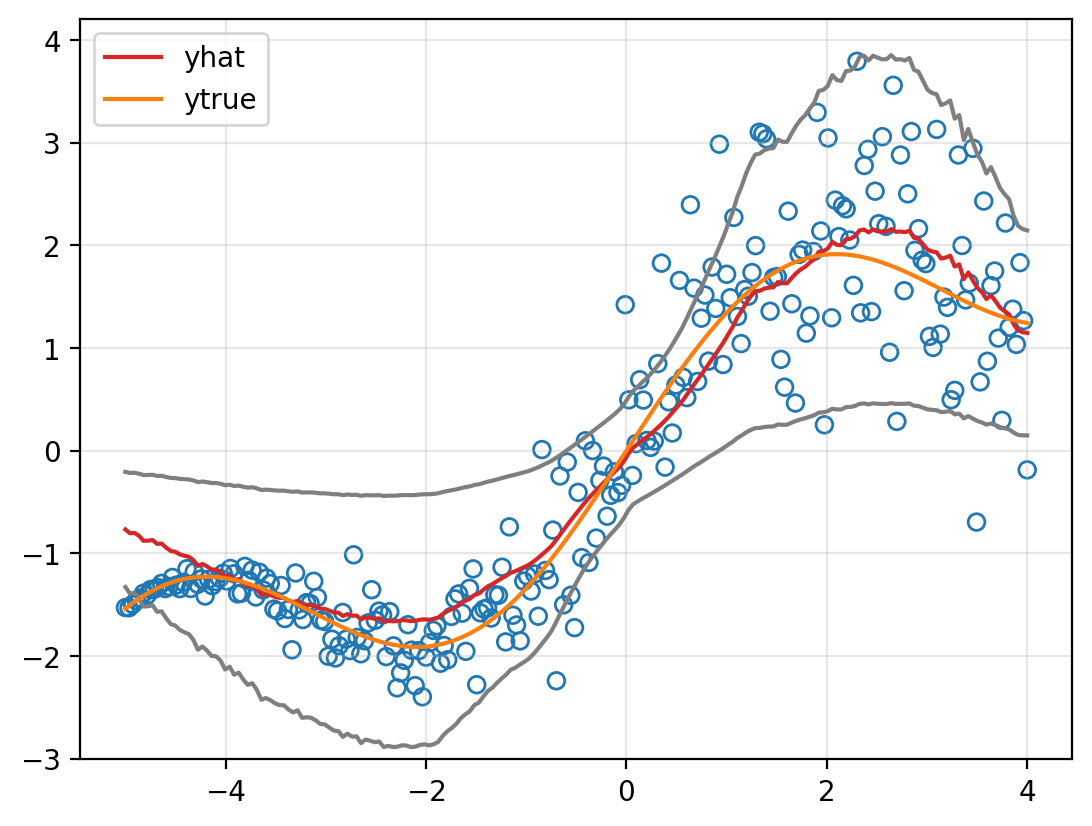

In [42]:
mean_eval = preds_eval[:, 0]
std_eval = jnp.sqrt(preds_eval[:, 1]/2)

plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

plt.plot(xeval, mean_eval, c="tab:red", label="yhat")
plt.plot(xeval, xeval / 2 + jnp.sin(xeval), c="tab:orange", label="ytrue")
plt.scatter(x, y, edgecolor="tab:blue", color="none")
plt.legend()
plt.ylim(-3, 4.2)
plt.grid(alpha=0.3)

In [44]:
eta = agent.link_fn(bel.mean, X)
preds = jax.vmap(agent.mean, 1)(eta)

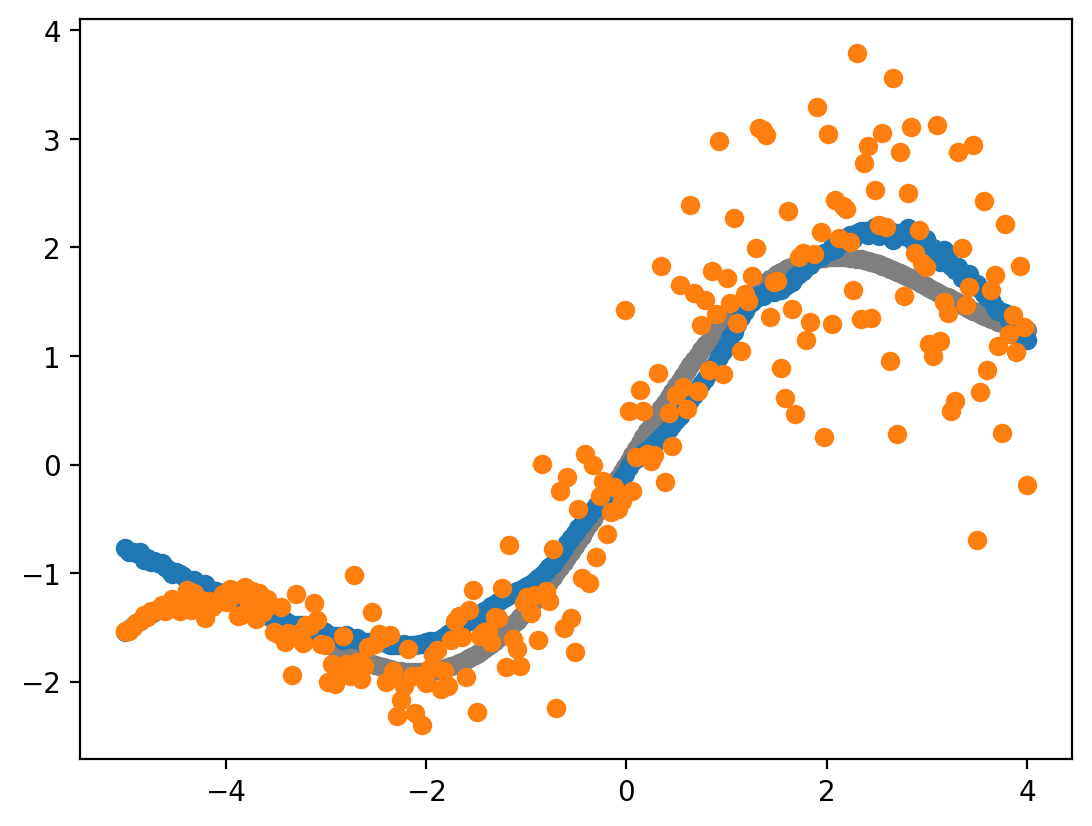

In [45]:
plt.scatter(x, y_clean, c="tab:gray")
plt.scatter(x, preds[:, 0])
plt.scatter(x, y)

## Animating

MovieWriter ffmpeg unavailable; using Pillow instead.


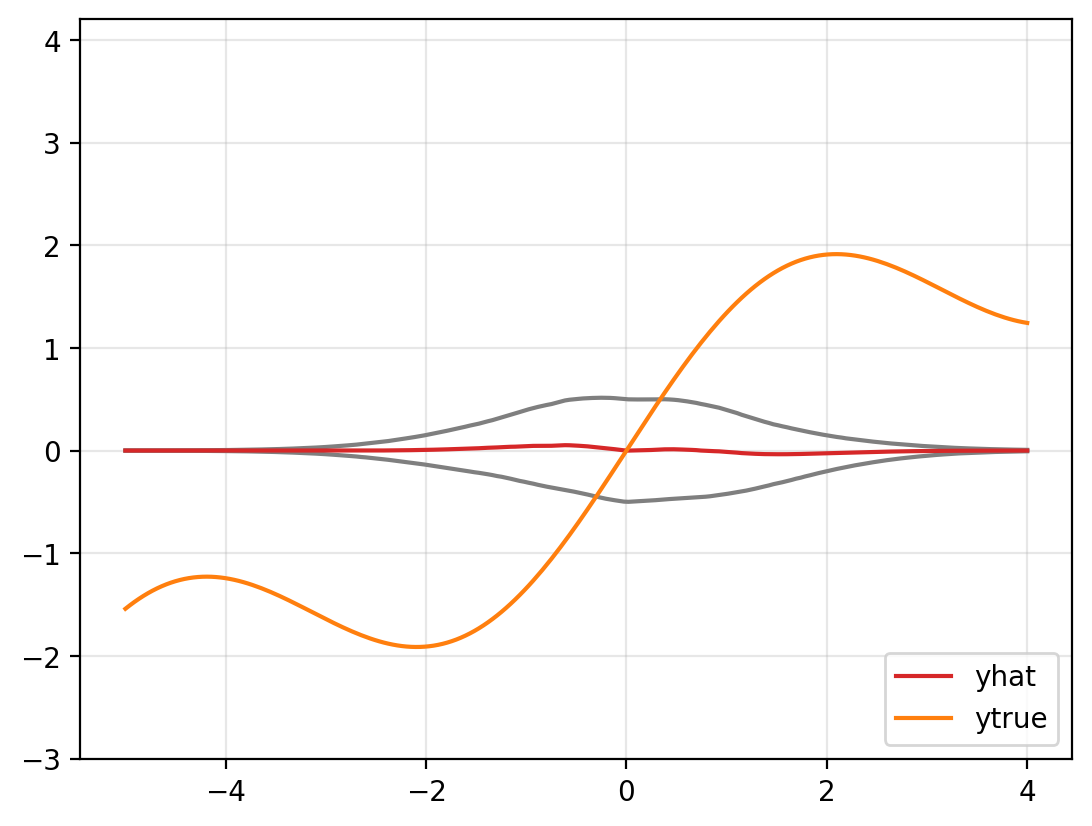

In [46]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    eta_eval = agent.link_fn(bel.mean, Xeval)
    preds_eval = jax.vmap(agent.mean, 1)(eta_eval)
    preds_eval = jax.tree_map(np.array, preds_eval)

    mean_eval = preds_eval[:, 0]
    std_eval = jnp.sqrt(preds_eval[:, 1] / 2)

    plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
    plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

    plt.plot(xeval, mean_eval, c="tab:red", label="yhat")
    plt.plot(xeval, xeval / 2 + jnp.sin(xeval), c="tab:orange", label="ytrue")
    plt.scatter(x[:t], y[:t], edgecolor="tab:blue", color="none")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.ylim(-3, 4.2)

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("hetgauss-ekf.gif", fps=20)

## Gaussian heteroskedastic with multinomial

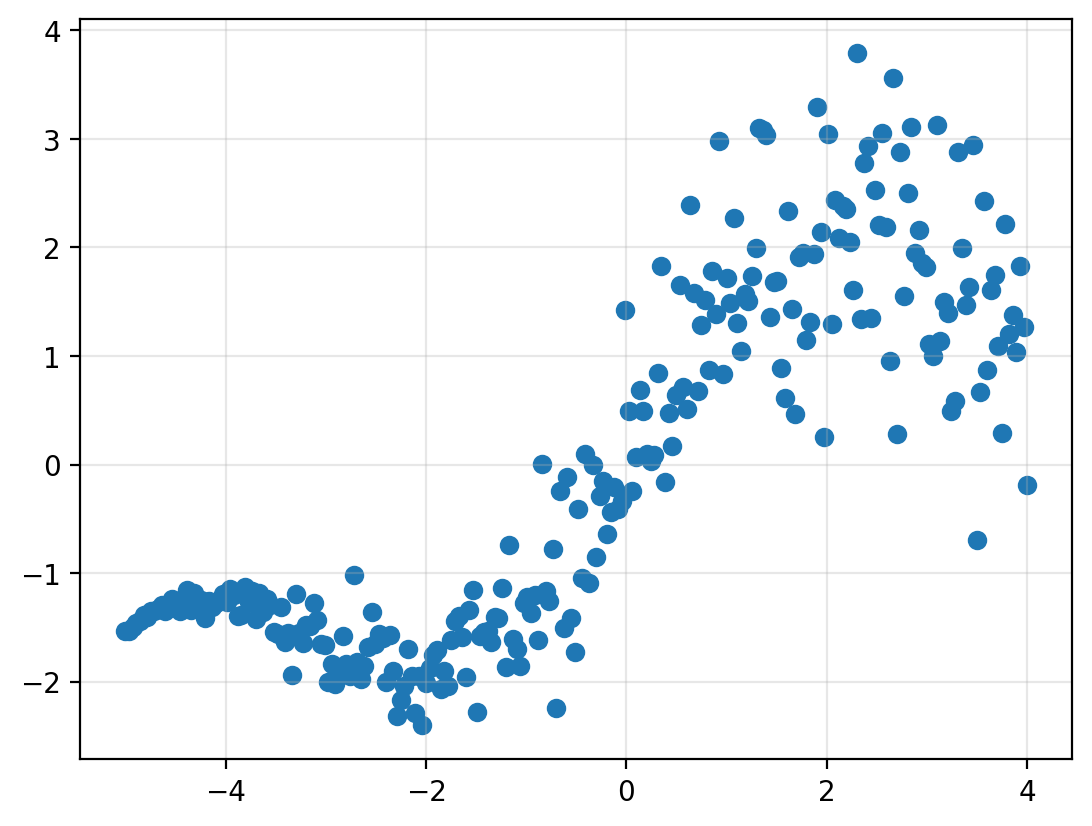

In [47]:
key = jax.random.PRNGKey(314)
key_data, key_train = jax.random.split(key)

n_samples = 250
key_x, key_y = jax.random.split(key_data)

key_noise, key_y = jax.random.split(key_y)
err = jax.random.normal(key_y, (n_samples,))

x = jnp.linspace(-5, 4, n_samples)

scales = jnp.linspace(0.01, 1.0, n_samples)
# scales = np.sqrt(jnp.exp(x / 2))
err = err * scales


y_clean = 0.5 * x + jnp.sin(x)
y = y_clean + err

ixs_new = jax.random.choice(key_x, n_samples, (n_samples,), replace=False)
x, y = x[ixs_new], y[ixs_new]
y_clean = y_clean[ixs_new]

X = basis_transform(x[:, None])
X = ((x - x.mean()) / x.std())[:, None]

plt.scatter(x, y)
plt.grid(alpha=0.3)

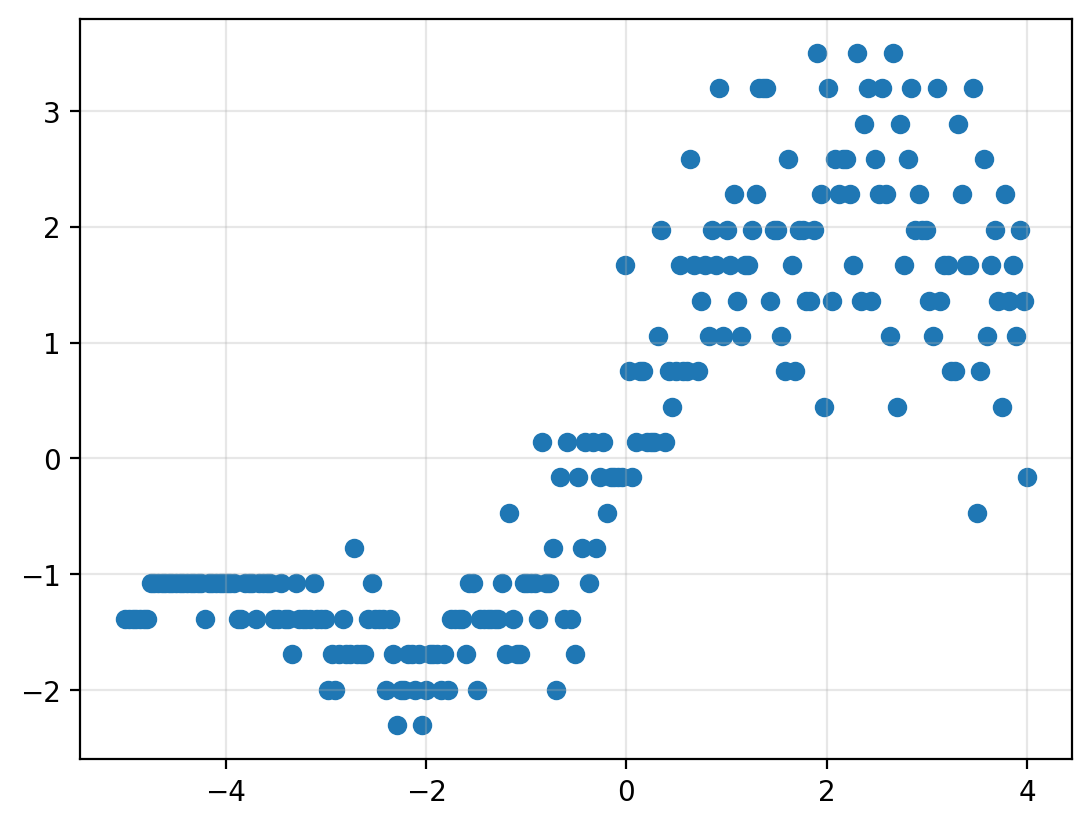

In [48]:
k = 20
bins = jnp.linspace(-2.3, 3.5, k)
ycat = jnp.digitize(y, bins)
yohe = jax.nn.one_hot(ycat, k)

plt.scatter(x, bins[ycat])
plt.grid(alpha=0.3)

In [49]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        
        eta = nn.Dense(k)(x)
        return eta
    
model = MLP()
params = model.init(key, X)

In [50]:
def log_partition(eta):
    return jnp.log1p(jnp.exp(eta).sum())

def suff_stat(y):
    return y

agent = ekf.ExpfamExtendedKalmanFilter(
    model.apply,
    log_partition,
    suff_stat,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=1e-2)
bel, bel_hist = agent.scan(bel_init, X, yohe)

In [51]:
# Link function
eta = agent.link_fn(bel_init.mean, X[0])

In [53]:
etas = agent.link_fn(bel.mean, X)
yhat = jax.vmap(agent.mean)(etas)

yhat.argmax(axis=1)

Array([ 4, 13,  7,  4,  4,  7, 10, 13,  4, 13, 13,  4,  7,  4,  4, 13,  4,
        4,  7, 13,  4,  4, 13,  4,  7,  4, 10,  4,  4,  4, 10,  4,  4,  4,
        4,  4, 13, 13, 13,  4, 13,  4, 10, 13, 13,  4,  4,  4, 13, 13,  7,
        4,  4,  4, 10,  4,  4,  4,  7,  4, 13,  4, 10, 13,  3,  4,  7, 13,
        4, 13,  4, 13, 13,  4,  4, 13,  4, 10, 13,  4,  7, 10,  4,  4,  4,
        4,  4,  4, 10, 10,  4, 10,  4,  4, 13, 13,  4,  4, 13, 10,  4,  4,
       10, 13,  4,  4, 13,  4,  4,  4, 13,  4,  4,  4,  7,  4,  4, 13, 10,
        4,  4, 13, 10,  4, 10, 13, 10,  7,  4, 13,  4, 10, 13,  4,  4,  7,
        4, 13,  4,  4,  4, 13, 13, 10,  4, 13, 10, 10,  3,  4, 13, 13, 13,
       13,  4,  4,  4, 13,  4, 13, 13, 13,  4,  7,  4, 10,  4, 10, 13, 10,
        4, 10,  3,  4, 13,  4,  4, 13,  4, 13,  4,  4, 13,  4,  7, 13,  4,
       10,  4, 13,  4, 10, 10, 13,  4, 10, 13,  4,  4,  4,  4,  4, 13, 13,
        4,  4,  4, 13,  3, 13,  4,  3,  4, 13, 13, 10,  4, 13, 13,  4, 13,
       10, 13,  4, 13,  4

In [54]:
yhat_cat = yhat.argmax(axis=1)
(yhat_cat == ycat).mean()

Array(0.272, dtype=float32)

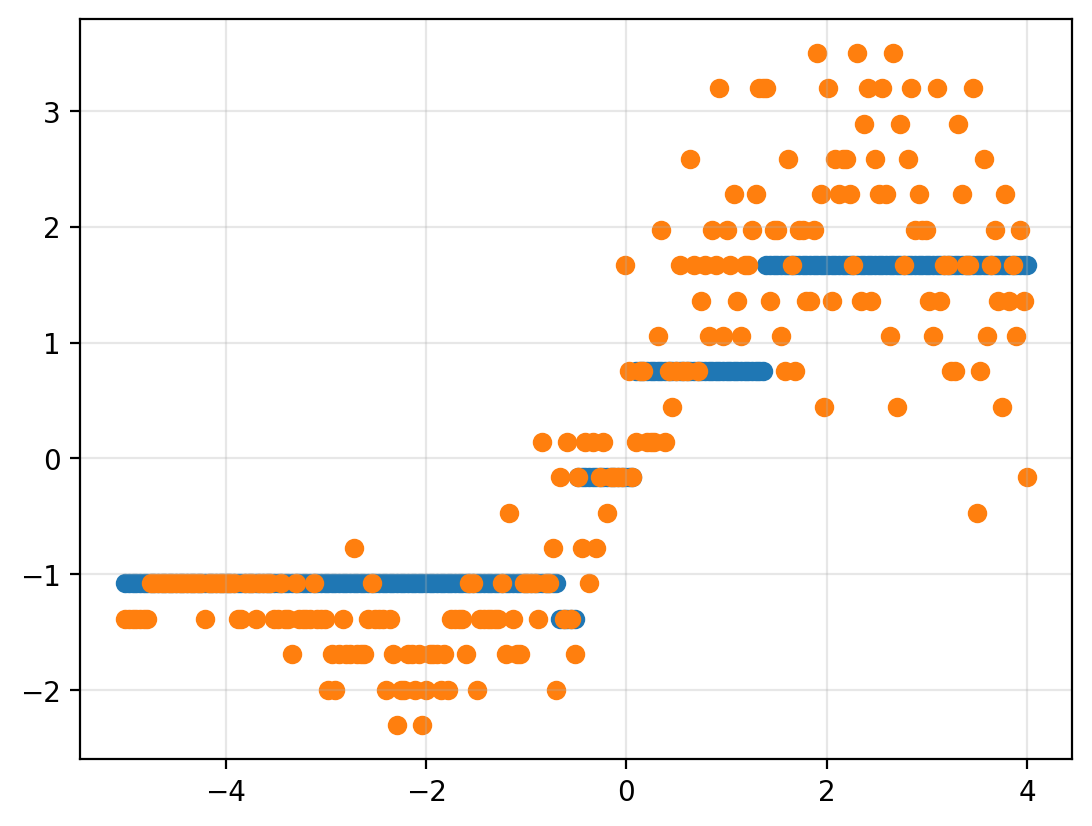

In [55]:
yhat_bin = bins[yhat.argmax(axis=1)]
plt.scatter(x, yhat_bin)
plt.scatter(x, bins[ycat])
# plt.scatter(x, (yhat * bins[None, :]).sum(axis=1), c="tab:red")
plt.grid(alpha=0.3)

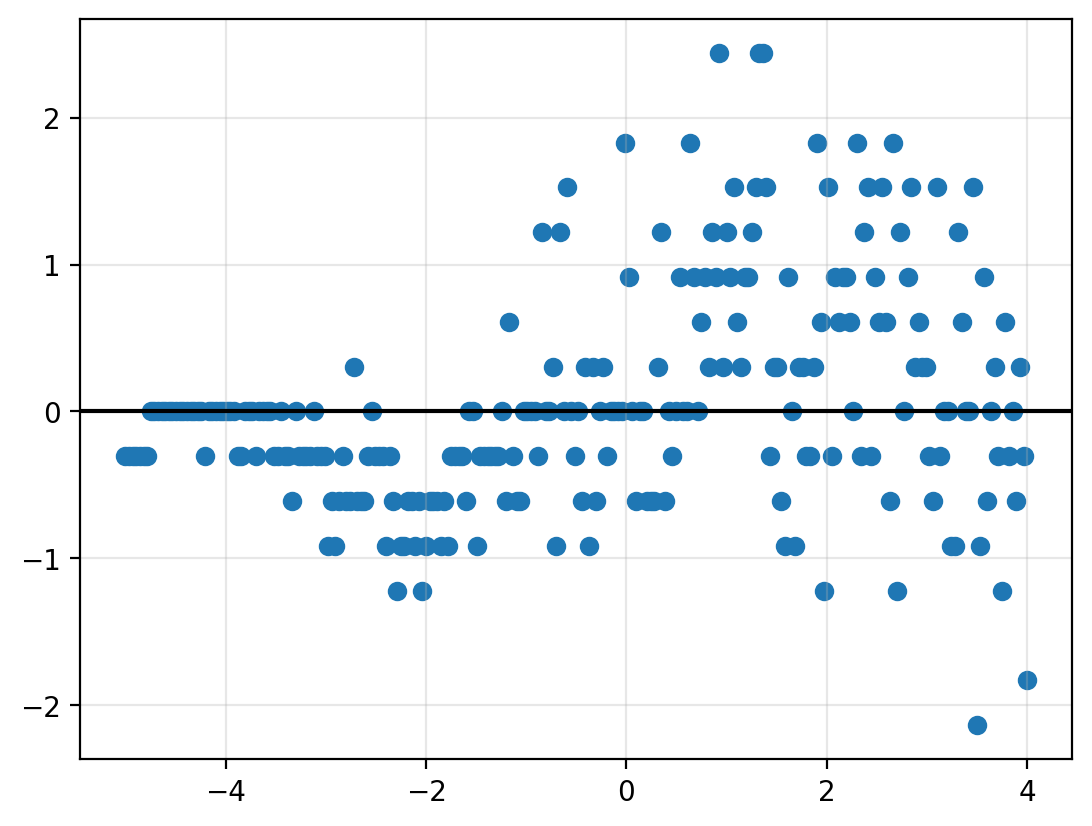

In [56]:
plt.scatter(x, bins[ycat] - yhat_bin)
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

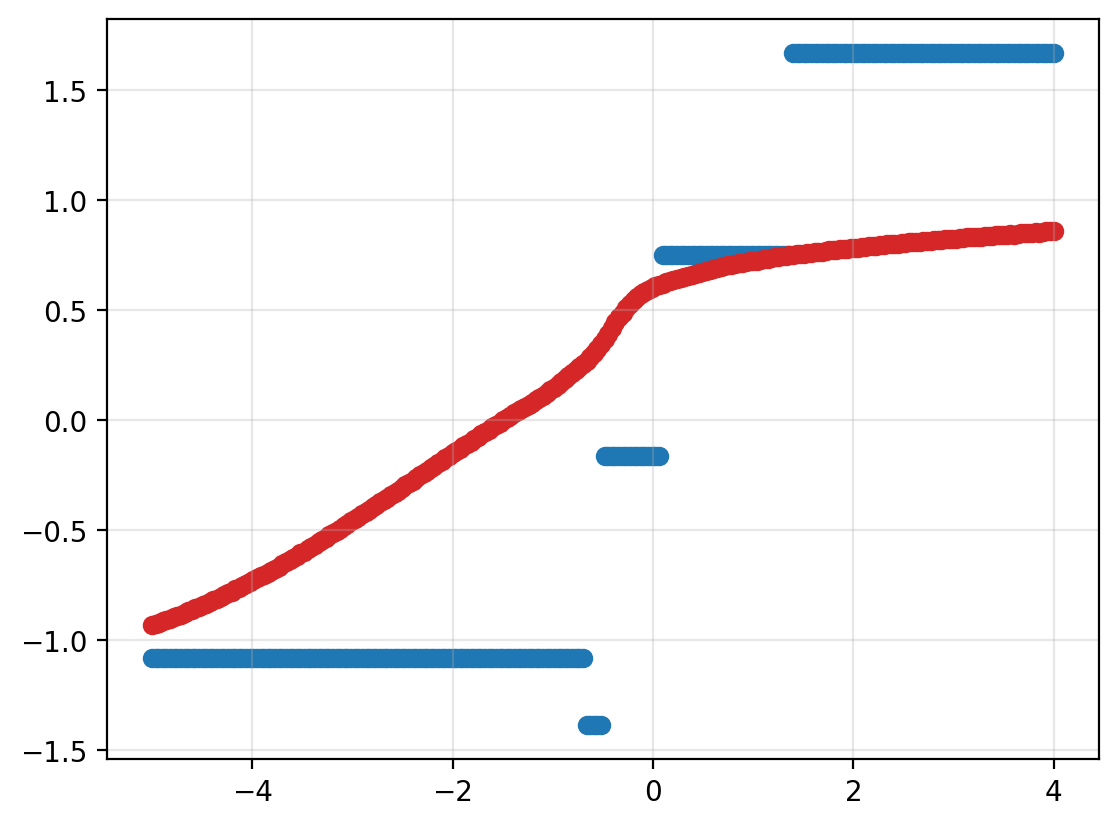

In [57]:
yhat_bin = bins[yhat.argmax(axis=1)]
plt.scatter(x, yhat_bin)
plt.scatter(x, (yhat * bins[None, :]).sum(axis=1), c="tab:red")
plt.grid(alpha=0.3)

# References
* [The Extended Kalman Filter is a Natural Gradient Descent in Trajectory Space](http://www.yann-ollivier.org/rech/publs/kalnat.pdf)
* [Table of exponential families](https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions)